# Comparison of Recomender System using TF-IDF and Bag of Words Vectorization Methods

This project involves building a movie recommendation system based on natural language processing (NLP) techniques, specifically utilizing TF-IDF and Bag of Words approaches. The analysis is conducted in three different contexts: Comedy, War, and Finance.


Keywords:<br>
Recomender System, Natural Language Processing(NLP), Term Frequency - Inverse Document Frequency(TF-IDF), Bag of Words, Cosine Similarity,Text Vectorization,PySpark, Data Preprocessing, Text Data Analysis, Netflix Data, Text Mining, Python.

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=4b8d53422ac712cacb1a0a883581d4414fd840b81928f923d70afa53adccfe4e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd

import scipy
from sklearn.metrics.pairwise import cosine_similarity

from pyspark.sql.functions import concat_ws, lower, regexp_replace, concat_ws
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.functions import vector_to_array

import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import os

In [3]:
# validating data existence in the current directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/netflix-shows/netflix_titles.csv


In [4]:
# initialize pyspark
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.appName("spark_nlp_01").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/12 03:27:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# raw data
raw = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
raw.shape

(8807, 12)

In [6]:
 raw.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [8]:
# check for NaN values
raw.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [9]:
# unique values in each column
raw.nunique()

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

In [10]:
fig = px.bar(pd.DataFrame([raw.nunique()]).melt(), x='variable', y='value', text='value', color='variable', title='Barplot with Unique Values for Columns')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.show()

- I was expecting the desctiption to be unique to each show, lest explore why some shows have the exact same description but different title

# Find rows which have the same description and remove one of them

In [11]:
raw2 = raw.sort_values('description')

In [12]:
shows_to_exclude = []
for i in range(1, raw2.shape[0]):
    if raw2.iloc[i]['description'].lower() == raw2.iloc[i-1]['description'].lower(): 
        shows_to_exclude.append(raw2.iloc[i]['show_id'])
        print(i-1, i)

161 162
1000 1001
1155 1156
1156 1157
1389 1390
1772 1773
1828 1829
2234 2235
2284 2285
2529 2530
2548 2549
2552 2553
2561 2562
2864 2865
2969 2970
2970 2971
3126 3127
3967 3968
5373 5374
5407 5408
5408 5409
5526 5527
5675 5676
5676 5677
5677 5678
5996 5997
6433 6434
7031 7032
7567 7568
7767 7768
8340 8341
8680 8681


In [13]:
raw2.iloc[161:163]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
78,s79,Movie,Tughlaq Durbar,Delhiprasad Deenadayalan,"Vijay Sethupathi, Parthiban, Raashi Khanna",NaN,"September 11, 2021",2020,TV-14,145 min,"Comedies, Dramas, International Movies",A budding politician has devious plans to rise...
79,s80,Movie,Tughlaq Durbar (Telugu),Delhiprasad Deenadayalan,"Vijay Sethupathi, Parthiban, Raashi Khanna",NaN,"September 11, 2021",2021,TV-14,145 min,"Comedies, Dramas, International Movies",A budding politician has devious plans to rise...


In [14]:
raw2.iloc[1000:1002]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
2969,s2970,Movie,Together For Eternity,Sooraj R. Barjatya,"Salman Khan, Karisma Kapoor, Saif Ali Khan, Ta...",India,"February 1, 2020",1999,TV-G,176 min,"Dramas, International Movies, Music & Musicals",A scheming matriarch plots to cut off her disa...
7022,s7023,Movie,Hum Saath-Saath Hain,Sooraj R. Barjatya,"Salman Khan, Karisma Kapoor, Saif Ali Khan, Ta...",India,"January 1, 2018",1999,TV-G,176 min,"Dramas, International Movies, Music & Musicals",A scheming matriarch plots to cut off her disa...


- Now we know that when a movie is offered in multiple languages, it creates a new instance with the exact same description but different title
- Highly repetative words can result in overinflating the importance of some words leading to skewed similarity scores. However repetative words can be helpful in cases when these are a good representative of the shows context.
- Many times the description of the title is short and could not cover the shows context entirely, thus I believe removing the rows with same description(dubbed titles) will not impact the recomendatins much negatively.

In [15]:
# Keeping only one row or show with same description
raw = raw[~raw['show_id'].isin(shows_to_exclude)]

In [16]:
raw.nunique()

show_id         8775
type               2
title           8775
director        4527
cast            7686
country          748
date_added      1766
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

# Data Pre-Processing and Feature Engineering Steps for mode = short (feature engineering)
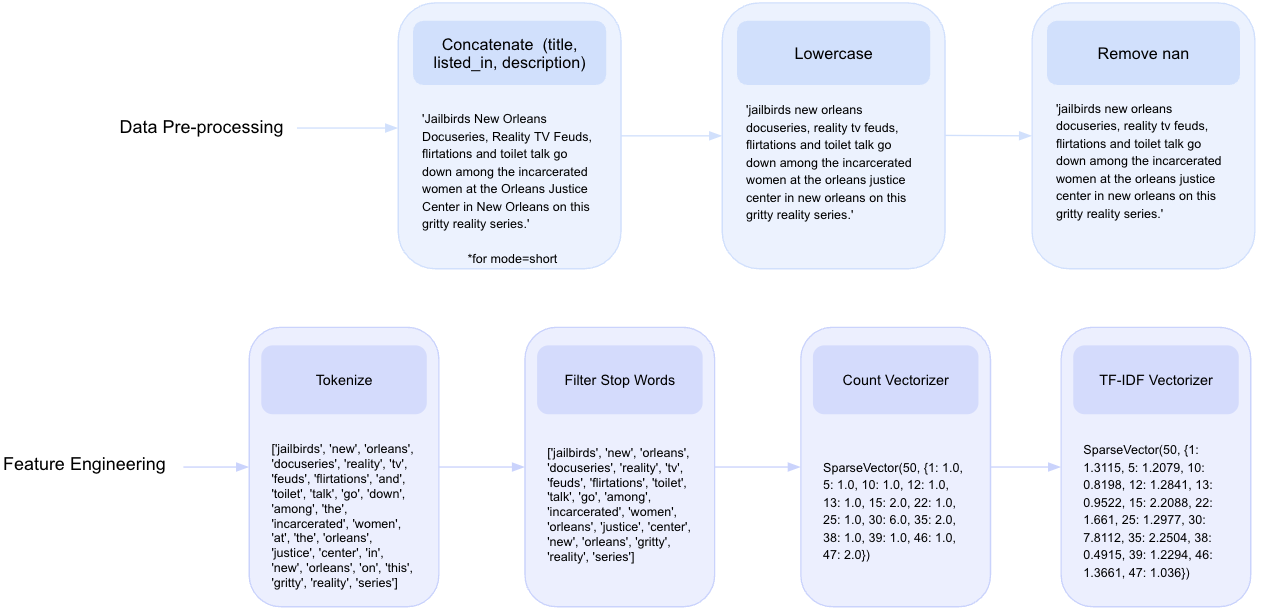

# NLP Class to aggregate script

In [17]:
class NLP:
    def __init__(self):
        self.file_location = '/kaggle/input/netflix-shows/netflix_titles.csv'
        
    def ProcessRawData(self):
        self.raw = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
        dfs = spark.createDataFrame(self.raw)

        # create training data - short: a new column "txt_input" by appending title, listed_in and description. 
        # convert to lower case and replace nan with empty string
        dfs_short = dfs.withColumn("txt_input", concat_ws(" ", "title", "listed_in", "description"))
        dfs_short = dfs_short.withColumn("txt_input", lower(dfs_short['txt_input']))
        dfs_short = dfs_short.withColumn('txt_input', regexp_replace('txt_input', 'nan ', ''))
        self.train_short = dfs_short['show_id', 'txt_input']
        
        # create training data - long:
        dfs_long = dfs.withColumn("txt_input", concat_ws(" ", "title", "director", "cast", "listed_in", "description"))
        dfs_long = dfs_long.withColumn("txt_input", lower(dfs_long['txt_input']))
        dfs_long = dfs_long.withColumn('txt_input', regexp_replace('txt_input', 'nan ', ''))
        self.train_long = dfs_long['show_id', 'txt_input']
        
    def FitPipeline(self):
        # split sentences into list of words
        tokenize = RegexTokenizer(inputCol="txt_input", 
                                      outputCol="tokenized", 
                                      pattern="[^a-z]")
        # remove stop words
        filter_st = StopWordsRemover(inputCol="tokenized", 
                                      outputCol="filtered")

        count_vectorizor = HashingTF(inputCol="filtered", 
                                        outputCol="count_vec", 
                                        numFeatures=50)
        
        tfidf_vectorizor = IDF(inputCol="count_vec", 
                                outputCol="features_tfidf")

        pipeline_tfidf = Pipeline(stages=[tokenize, 
                                        filter_st, 
                                        count_vectorizor,
                                        tfidf_vectorizor])
        
        # fit the pipeline
        self.pipe_short_fit = pipeline_tfidf.fit(self.train_short)
        features_short = self.pipe_short_fit.transform(self.train_short)
        # convert sparse matrix to dense
        self.features_short = features_short.withColumn('arr_features_tfidf', vector_to_array('features_tfidf'))\
                                    .withColumn('arr_features_cnt', vector_to_array('count_vec'))
        
        self.pipe_long_fit = pipeline_tfidf.fit(self.train_long)
        features_long = self.pipe_long_fit.transform(self.train_long)
        self.features_long = features_long.withColumn('arr_features_tfidf', vector_to_array('features_tfidf'))\
                                    .withColumn('arr_features_cnt', vector_to_array('count_vec'))
        
    def Search(self, txt_search, mode, feature, top_n=5):
        txt_search = txt_search.strip()
        if txt_search == '': raise ValueError("Invalid txt_search")
        if mode not in ['short', 'long']: raise ValueError("Mode must be either 'short' or 'long'")
        if feature not in ['tfidf', 'bow']: raise ValueError("Feature must be either 'tfidf' or 'bow'")
        if top_n < 1: raise ValueError("'top_n' must be atleast 1")
        
        self.ProcessRawData()
        self.FitPipeline()
        
        # apply pre-processing steps to the test data
        pred_raw = pd.DataFrame(data = {"txt_input":[txt_search]})
        pred_raw['txt_input'] = pred_raw['txt_input'].str.lower()
        test_input = spark.createDataFrame(pred_raw)

        if mode == 'short': 
            pred_features = self.pipe_short_fit.transform(test_input)
            train_features_df = self.features_short.toPandas()
        else: 
            pred_features = self.pipe_long_fit.transform(test_input)
            train_features_df = self.features_long.toPandas()

        pred_features = pred_features.withColumn('arr_features_tfidf', vector_to_array('features_tfidf'))\
                                        .withColumn('arr_features_cnt', vector_to_array('count_vec'))

        pred_features_df = pred_features.toPandas()
        
        # compute cosine similaity
        if feature == 'tfidf':
            pred_similarity = cosine_similarity(scipy.sparse.csr_matrix(list(train_features_df['arr_features_tfidf'].values)),
                                            scipy.sparse.csr_matrix(list(pred_features_df['arr_features_tfidf'].values)))
        else:
            pred_similarity = cosine_similarity(scipy.sparse.csr_matrix(list(train_features_df['arr_features_cnt'].values)),
                                            scipy.sparse.csr_matrix(list(pred_features_df['arr_features_cnt'].values))) 
    
        # search most relevant titles by sorting descending to cosine similarity 
        train_features_df['pred_similarity'] = pred_similarity

        if top_n <= train_features_df.shape[0]:
            top_n_df = train_features_df.sort_values(['pred_similarity'], ascending = False).head(top_n)
            
            for i in range(0, top_n_df.shape[0]):
                print(f'\n{str(i+1)}) Similarity Score: {str(top_n_df.iloc[i].pred_similarity)}')
                temp = self.raw[self.raw['show_id'] == top_n_df.iloc[i]['show_id']].copy()
                print(temp[['title', 'listed_in']])
                print(top_n_df.iloc[i]['txt_input'])
                #print(top_n_df.iloc[i]['filtered'])
        else: 
            raise ValueError("top_n must me less than ", train_features_df.shape[0])

# Analyzing recommendations for Bag of Words - Short

Analysis Parameters for mode = short and feature = bow(bag of words)<br>
search text = 'comedy sitcom funny humor fun joke clown'<br> 
           or 'war military battle invasion weapon soldier'<br>
            or 'finance business accounting wallstreet money credit bank'
            
Idea: Analyze each mode and feature performance for 3 different contexts comedy, war and finance

In [18]:
#1.1
x = NLP()
x.Search('comedy sitcom funny humor fun joke clown', mode='short', feature='bow')


1) Similarity Score: 0.68350674260132
                     title                           listed_in
6080  Abominable Christmas  Children & Family Movies, Comedies
abominable christmas children & family movies, comedies two small abominable snowmen flee their mountain to escape a scientist who's trying to capture them and end up spending christmas with a human family.

2) Similarity Score: 0.5916079783099615
                     title listed_in
8301  The First Wives Club  Comedies
the first wives club comedies following a friend's suicide after her husband dumps her for a younger model, three women plot payback against their two-timing exes.

3) Similarity Score: 0.5819143739626463
                        title         listed_in
4293  Springsteen on Broadway  Music & Musicals
springsteen on broadway music & musicals bruce springsteen shares personal stories from his life and acoustic versions of some of his best-known songs in an intimate one-man show.

4) Similarity Score: 0.57498890

In [19]:
# 1.2
x = NLP()
x.Search('war military battle invasion weapon soldier', mode='short', feature='bow')


1) Similarity Score: 0.5865884600854132
           title listed_in
7148  Julius Jr.  Kids' TV
julius jr. kids' tv paul frank's fun artwork comes to life in this show that follows monkey julius jr. and his friends as they explore the world and help each other out.

2) Similarity Score: 0.5715476066494083
                title                     listed_in
7173  Kaviyude Osyath  Dramas, International Movies
kaviyude osyath dramas, international movies when a late poet leaves behind his property to a young man, the man's brother suspects the poet may have been more than just a family friend.

3) Similarity Score: 0.5604485383178051
        title                            listed_in
4374  Sabrina  Horror Movies, International Movies
sabrina horror movies, international movies a toy manufacturer and his wife are terrorized by a demon after their orphaned niece tries to summon her late mother's spirit using a spooky ritual.

4) Similarity Score: 0.560112033611204
                           

In [20]:
# 1.3
x = NLP()
x.Search('finance business accounting wallstreet money credit bank', mode='short', feature='bow')


1) Similarity Score: 0.6585527740981746
     title                    listed_in
5028  Mute  Sci-Fi & Fantasy, Thrillers
mute sci-fi & fantasy, thrillers when his girlfriend vanishes, a mute man ventures into a near-future berlin's seamy underworld, where his actions speak louder than words.

2) Similarity Score: 0.6288281455225323
     title                     listed_in
6831  Gelo  Dramas, International Movies
gelo dramas, international movies a punjabi woman who works on a farm must endure the difficulties of living in an oppressive class-based society and a dysfunctional community.

3) Similarity Score: 0.5948118774794626
                              title        listed_in
5379  Tom Segura: Completely Normal  Stand-Up Comedy
tom segura: completely normal stand-up comedy levelheaded stand-up tom segura shares offhand appraisals on hotels and opens up about his hobbies and digestive ailments in this comedy special.

4) Similarity Score: 0.5773502691896257
            title          

### Analyzing recommendations for TF-IDF - Short

In [21]:
#2.1
x = NLP()
x.Search('comedy sitcom funny humor fun joke clown', mode='short', feature='tfidf')


1) Similarity Score: 0.7101992968975184
                     title                           listed_in
6080  Abominable Christmas  Children & Family Movies, Comedies
abominable christmas children & family movies, comedies two small abominable snowmen flee their mountain to escape a scientist who's trying to capture them and end up spending christmas with a human family.

2) Similarity Score: 0.648383934023484
          title                           listed_in
5648  Bee Movie  Children & Family Movies, Comedies
bee movie children & family movies, comedies barry, a worker bee stuck in a dead-end job making honey, sues humans when he learns they've been stealing bees' nectar all along.

3) Similarity Score: 0.6225335726575572
                       title                     listed_in
8718  Westside vs. the World  Documentaries, Sports Movies
westside vs. the world documentaries, sports movies a look into the journey of influential strength coach louie simmons and the westside barbell gy

In [22]:
# 2.2
x = NLP()
x.Search('war military battle invasion weapon soldier', mode='short', feature='tfidf')


1) Similarity Score: 0.6840504135625641
                title                     listed_in
7173  Kaviyude Osyath  Dramas, International Movies
kaviyude osyath dramas, international movies when a late poet leaves behind his property to a young man, the man's brother suspects the poet may have been more than just a family friend.

2) Similarity Score: 0.6590191496221467
        title                            listed_in
4374  Sabrina  Horror Movies, International Movies
sabrina horror movies, international movies a toy manufacturer and his wife are terrorized by a demon after their orphaned niece tries to summon her late mother's spirit using a spooky ritual.

3) Similarity Score: 0.6307578402917597
           title listed_in
7148  Julius Jr.  Kids' TV
julius jr. kids' tv paul frank's fun artwork comes to life in this show that follows monkey julius jr. and his friends as they explore the world and help each other out.

4) Similarity Score: 0.6257329290849255
                          

In [23]:
# 2.3
x = NLP()
x.Search('finance business accounting wallstreet money credit bank', mode='short', feature='tfidf')


1) Similarity Score: 0.7619904407284813
     title                    listed_in
5028  Mute  Sci-Fi & Fantasy, Thrillers
mute sci-fi & fantasy, thrillers when his girlfriend vanishes, a mute man ventures into a near-future berlin's seamy underworld, where his actions speak louder than words.

2) Similarity Score: 0.6769768113684066
                              title        listed_in
5379  Tom Segura: Completely Normal  Stand-Up Comedy
tom segura: completely normal stand-up comedy levelheaded stand-up tom segura shares offhand appraisals on hotels and opens up about his hobbies and digestive ailments in this comedy special.

3) Similarity Score: 0.6669540106350775
     title                     listed_in
6831  Gelo  Dramas, International Movies
gelo dramas, international movies a punjabi woman who works on a farm must endure the difficulties of living in an oppressive class-based society and a dysfunctional community.

4) Similarity Score: 0.6589962478282028
         title             

### Analyzing recommendations for Bag of Words - Long

In [24]:
#3.1
x = NLP()
x.Search('comedy sitcom funny humor fun joke clown', mode='long', feature='bow')


1) Similarity Score: 0.6131393394849658
                       title                     listed_in
8718  Westside vs. the World  Documentaries, Sports Movies
westside vs. the world michael fahey ron perlman, louie simmons documentaries, sports movies a look into the journey of influential strength coach louie simmons and the westside barbell gym he founded, evolving the sport of powerlifting.

2) Similarity Score: 0.5953405577875872
       title                                        listed_in
7144  Judwaa  Comedies, International Movies, Romantic Movies
judwaa david dhawan salman khan, karisma kapoor, rambha, kader khan, anupam kher, shakti kapoor, bindu, reema lagoo, satish shah, mukesh rishi comedies, international movies, romantic movies separated at birth, a pair of identical twins unexpectedly reunite as adults and embark on a madcap mission to take down a common enemy from their past.

3) Similarity Score: 0.5953405577875871
                     title                           

In [25]:
# 3.2
x = NLP()
x.Search('war military battle invasion weapon soldier', mode='long', feature='bow')


1) Similarity Score: 0.629852058044962
                                       title                    listed_in
7181  Kevyn Aucoin: Beauty & the Beast in Me  Documentaries, LGBTQ Movies
kevyn aucoin: beauty & the beast in me lori kaye kevyn aucoin, cindy crawford, naomi campbell, gwyneth paltrow, andie macdowell, paulina porizkova, amber valletta documentaries, lgbtq movies makeup artist kevyn aucoin worked with top supermodels in the 1980s and 1990s. personal videos merged with interviews provide a peek into his life.

2) Similarity Score: 0.5985056016645798
                       title                  listed_in
8055  Something's Gotta Give  Comedies, Romantic Movies
something's gotta give nancy meyers jack nicholson, diane keaton, keanu reeves, frances mcdormand, amanda peet, jon favreau, paul michael glaser, rachel ticotin comedies, romantic movies still sexy at 60, harry sanborn wines and dines women half his age. but a getaway with his girlfriend goes awry when her mother drops

In [26]:
# 3.3
x = NLP()
x.Search('finance business accounting wallstreet money credit bank', mode='long', feature='bow')


1) Similarity Score: 0.647150228929434
     title                    listed_in
5028  Mute  Sci-Fi & Fantasy, Thrillers
mute duncan jones alexander skarsgård, paul rudd, justin theroux sci-fi & fantasy, thrillers when his girlfriend vanishes, a mute man ventures into a near-future berlin's seamy underworld, where his actions speak louder than words.

2) Similarity Score: 0.641015965093882
                              title        listed_in
2952  Tom Papa: You're Doing Great!  Stand-Up Comedy
tom papa: you're doing great! gregory jacobs tom papa stand-up comedy comedian tom papa takes on body image issues, social media, pets, staten island, the "old days" and more in a special from his home state of new jersey.

3) Similarity Score: 0.6350528962771202
                              title        listed_in
5379  Tom Segura: Completely Normal  Stand-Up Comedy
tom segura: completely normal jay chapman tom segura stand-up comedy levelheaded stand-up tom segura shares offhand appraisals on ho

### Analyzing recommendations for TF-IDF - Long

In [27]:
#4.1
x = NLP()
x.Search('comedy sitcom funny humor fun joke clown', mode='long', feature='tfidf')


1) Similarity Score: 0.6445929825310162
          title                                      listed_in
7247  Kya Kehna  Dramas, International Movies, Romantic Movies
kya kehna kundan shah preity zinta, saif ali khan, anupam kher, farida jalal, chandrachur singh dramas, international movies, romantic movies a young university student's world is shaken after her brief involvement with a wealthy playboy results in her pregnancy.

2) Similarity Score: 0.6352007996887277
                       title                     listed_in
8718  Westside vs. the World  Documentaries, Sports Movies
westside vs. the world michael fahey ron perlman, louie simmons documentaries, sports movies a look into the journey of influential strength coach louie simmons and the westside barbell gym he founded, evolving the sport of powerlifting.

3) Similarity Score: 0.6308635099707676
       title                                        listed_in
7144  Judwaa  Comedies, International Movies, Romantic Movies
judwaa 

In [28]:
# 4.2
x = NLP()
x.Search('war military battle invasion weapon soldier', mode='long', feature='tfidf')


1) Similarity Score: 0.6353713319330334
                                       title                    listed_in
7181  Kevyn Aucoin: Beauty & the Beast in Me  Documentaries, LGBTQ Movies
kevyn aucoin: beauty & the beast in me lori kaye kevyn aucoin, cindy crawford, naomi campbell, gwyneth paltrow, andie macdowell, paulina porizkova, amber valletta documentaries, lgbtq movies makeup artist kevyn aucoin worked with top supermodels in the 1980s and 1990s. personal videos merged with interviews provide a peek into his life.

2) Similarity Score: 0.611055738052067
                              title  \
6628  Don't Crack Under Pressure II   

                                              listed_in  
6628  Action & Adventure, Documentaries, Internation...  
don't crack under pressure ii thierry donard davide carrera, eric duguil, jesse richman, richie jackson, loic collomb-patton, wille lindberg, matt annetts action & adventure, documentaries, international movies using state-of-the-art tec

In [29]:
# 4.3
x = NLP()
x.Search('finance business accounting wallstreet money credit bank', mode='long', feature='tfidf')


1) Similarity Score: 0.7214469977876345
     title                    listed_in
5028  Mute  Sci-Fi & Fantasy, Thrillers
mute duncan jones alexander skarsgård, paul rudd, justin theroux sci-fi & fantasy, thrillers when his girlfriend vanishes, a mute man ventures into a near-future berlin's seamy underworld, where his actions speak louder than words.

2) Similarity Score: 0.6984603812566813
                              title        listed_in
5379  Tom Segura: Completely Normal  Stand-Up Comedy
tom segura: completely normal jay chapman tom segura stand-up comedy levelheaded stand-up tom segura shares offhand appraisals on hotels and opens up about his hobbies and digestive ailments in this comedy special.

3) Similarity Score: 0.6873038727581305
           title listed_in
527  Puffin Rock  Kids' TV
puffin rock chris o'dowd, kate mccafferty, sally mcdaid, geraldine cole, brian mcmonagle, darragh gargan kids' tv life is sweet on beautiful puffin rock, where puffling oona, her baby brothe

# Summary of the Analysis:

- Comedy Context:
    - Best Results: The recommendations for the comedy context had the highest relevance.
    - Movies Suggested:
        - Kya Kehna (Genres: Dramas, International Movies, Romantic Movies)
        - Westside vs. the World (Genres: Documentaries, Sports Movies)
        - Judwaa (Genres: Comedies, International Movies, Romantic Movies)
        - Becoming (Genres: Documentaries)
        - Abominable Christmas (Genres: Children & Family Movies, Comedies)
- War Context:
    - Best Results: The best recommendations for the war context were with parameters: Bag of Words and Short Feature engineering.
    - Relevant Words in Recommendations: Words like crime, terrorized, serial killer were very relevant.
    - Movies Suggested:
        - Kevyn Aucoin: Beauty & the Beast in Me (Genres: Documentaries, LGBTQ Movies)
        - Don't Crack Under Pressure II (Genres: Action & Adventure, Documentaries, International Movies)
        - Chandani: The Daughter of the Elephant Whisperer (Genres: Documentaries, International Movies)
        - Harud (Genres: Dramas, International Movies)
        - Ani... Dr. Kashinath Ghanekar (Genres: Dramas, International Movies)
- Finance Context:
    - Observation: Recommendations for the finance context were not as good, with many results being in the romantic or comedy genres.
    - Movies Suggested:
        - Mute (Genres: Sci-Fi & Fantasy, Thrillers)
        - Tom Segura: Completely Normal (Genre: Stand-Up Comedy)
        - Puffin Rock (Genre: Kids' TV)
        - Bird Box (Genres: Dramas, Sci-Fi & Fantasy, Thrillers)
        - Tom Papa: You're Doing Great! (Genre: Stand-Up Comedy)
- General Observations:
    - Best Performing Models: Bag of Words and Short Feature engineering provided the best results for the war context.
    - TF-IDF Performance: Generally, TF-IDF performed slightly better than Bag of Words, especially for the long context.
    - Average Similarity Scores: Overall, TF-IDF had higher average similarity scores than Bag of Words.
- TF-IDF Advantages:
    - Generally higher average similarity scores.
    - Particularly effective for the long context.
- Bag of Words Advantages:
    - Best performing in the war context, especially with short feature engineering.
    - Simplicity and ease of implementation.



Feel free to explore the project, contribute, or provide feedback!